# Road Segmentation Project


In [1]:
# Imports
import torch
import numpy as np
from parameters import *

from utils import utils
import trainer

import dataset

import matplotlib.pyplot as plt
from torch import nn

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset, val_dataset = dataset.load_all_data(
    ROOT_PATH,
    device,
    BATCH_SIZE,
    use_patches=False,
    val_size=VAL_SIZE,
    resize_to=None
)

KeyboardInterrupt: 

# Baselines

## Baseline 1: UNet 
This is the provided baseline U-Net with F1 score of 86%.

## Baseline 2: ResU-Net --> Road Extraction by Deep Residual U-Net
This is the provided baseline U-Net with F1 score of 89%.

In [3]:
class Block(torch.nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)


class UNet(torch.nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel


def accuracy_fn(y_pred, y_true):
    return ((y_pred > 0.5) == (y_true > 0.5)).float().mean().item()

def patches_pred(y):
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    pred = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return pred

def patch_accuracy_fn(y_hat: torch.Tensor, y: torch.Tensor):
    return (patches_pred(y_hat) == patches_pred(y)).float().mean().item()

def f1_score(y_pred, y_true):
    prec_array = y_true[y_pred]
    if len(prec_array) == 0:
        return 0.0
    precision = prec_array.float().mean()

    rec_array = y_pred[y_true]
    if len(rec_array) == 0:
        return 0.0
    recall = rec_array.float().mean()
    if precision == 0 or recall == 0:
        return 0.0
    return (2 * precision * recall / (precision + recall)).item()

def f1_score_fn(y_pred, y_true):
    return f1_score(y_pred > 0.5, y_true > 0.5)

def f1_score_patches_fn(y_pred, y_true):
    return f1_score(patches_pred(y_pred), patches_pred(y_true))
    

In [4]:
model = UNet().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
metrics = {
    'acc': accuracy_fn,
    'patch_acc': patch_accuracy_fn,
    'f1_score': f1_score_fn,
    'f1_score_patches': f1_score_patches_fn
}

trainer.train(train_dataset, val_dataset, model, loss_fn, metrics, optimizer, N_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

	- loss = 0.5004590734839439
  	- val_loss = 0.47658199816942215
  	- acc = 0.7974300146102905
  	- val_acc = 0.8169630318880081
  	- patch_acc = 0.6370266735553741
  	- val_patch_acc = 0.7434000074863434
  	- f1_score = 0.026525419663084904
  	- val_f1_score = 0.0
  	- f1_score_patches = 0.13067130725830794
  	- val_f1_score_patches = 0.0
 
	- loss = 0.47105088233947756
  	- val_loss = 0.4773401618003845
  	- acc = 0.8230350643396378
  	- val_acc = 0.8169630318880081
  	- patch_acc = 0.74770667552948
  	- val_patch_acc = 0.7434000223875046
  	- f1_score = 0.0
  	- val_f1_score = 0.0
  	- f1_score_patches = 0.02015836916398257
  	- val_f1_score_patches = 0.0
 
	- loss = 0.4686984524130821
  	- val_loss = 0.4762158989906311
  	- acc = 0.8230350553989411
  	- val_acc = 0.8169630318880081
  	- patch_acc = 0.7498266756534576
  	- val_patch_acc = 0.7434000074863434
  	- f1_score = 0.0
  	- val_f1_score = 0.0
  	- f1_score_patches = 0.020437025069259106
  	- val_f1_score_patches = 0.0
 
	- l

KeyboardInterrupt: 

In [5]:
%load_ext tensorboard
%tensorboard --logdir ./tensorboard


In [5]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

Epoch 1/100:   0%|          | 0/33 [00:00<?, ?it/s]

	- loss = 0.5807683792981234
  	- val_loss = 0.6202654838562012
  	- f1_train = tensor(3.6211, device='cuda:0')
  	- f1_val = tensor(1.9567, device='cuda:0')
  	- patch_acc = 0.7210911241444674
  	- val_patch_acc = 0.6507161557674408
 
3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.220965..21.96553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22.379751..50.19854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.019249..40.17603].


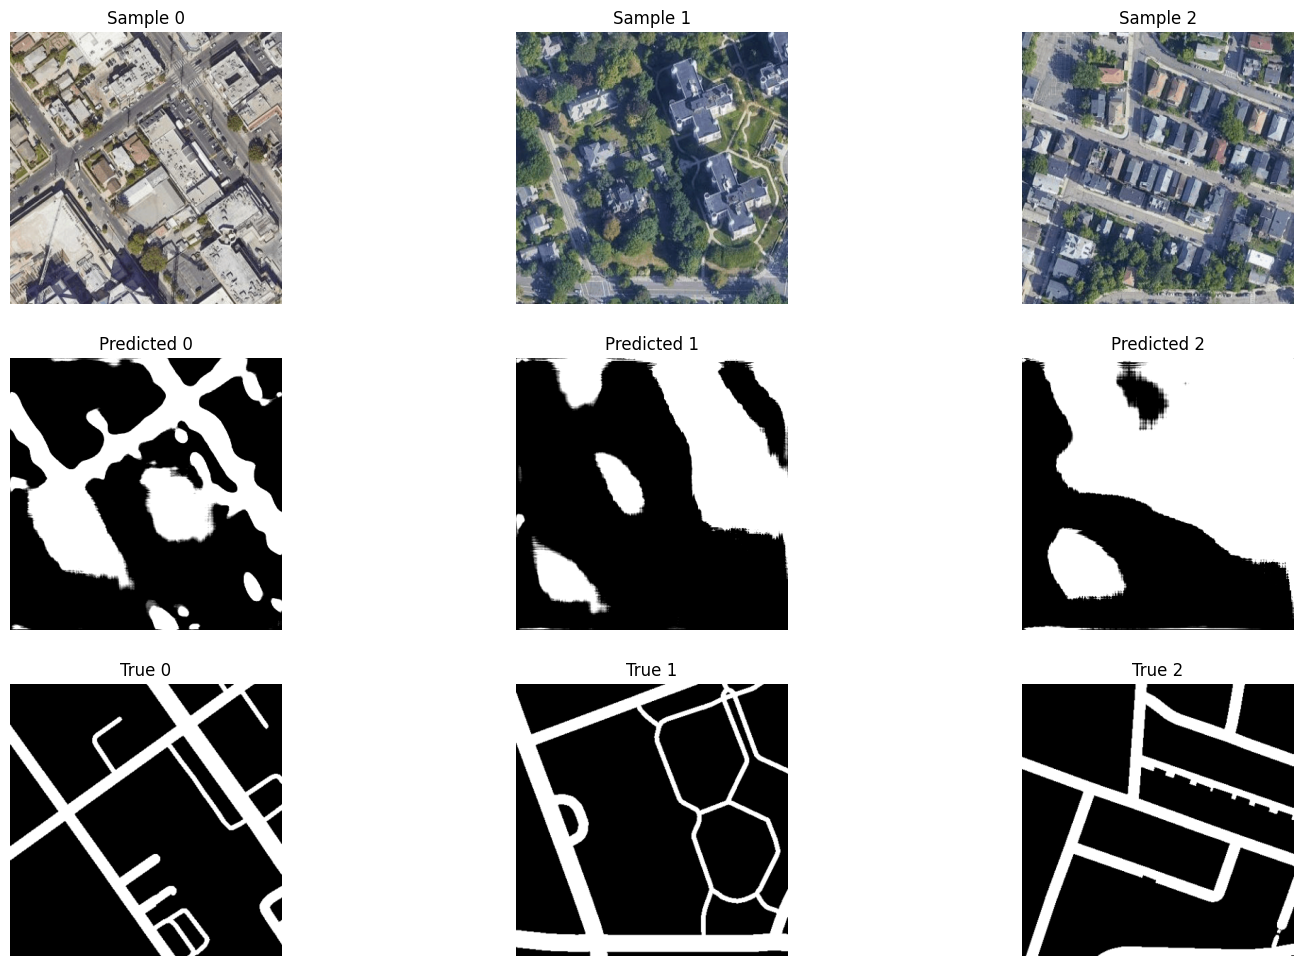

Epoch 2/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# TRAINING WITH VALIDATIONs
# for image segmentation dice loss could be the best first choice
model = model.to(device)
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
metric_fns = {'patch_acc': trainer.patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
trainer.train_smp(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, 100, 20)

Epoch 1/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/36 [00:00<?, ?it/s]

Finished Training


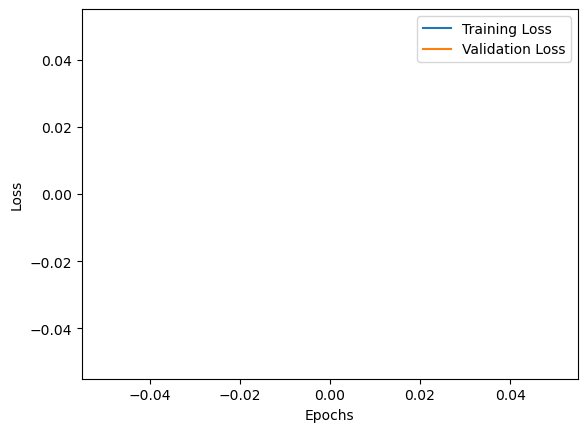

In [10]:
# TRAINING WITHOUT VALIDATION ON FULL DATASET

model_full = smp.UnetPlusPlus(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model_full = model_full.to(device)
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
metric_fns = {'patch_acc': trainer.patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
trainer.train_smp(full_dataloader, None, model, loss_fn, metric_fns, optimizer, 100, 20)

In [9]:
utils.create_submission("test", "images",'resunet_submission.csv', model, device)

In [ ]:
import resunet

In [ ]:
model = resunet.ResUnet(3).to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': trainer.accuracy_fn, 'patch_acc': trainer.patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
trainer.train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, 100)

In [ ]:
utils.create_submission("test", "images",'resunet_submission.csv', model, device)

# Upgrade 1 - Using Transfer Learning for the Encoder
In the architecture of the U-Net, the encoder is replaced with pretrained VGG16 model.

### Training


## Upgrade 2 - CGAN --> https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8628717
In the paper, they use a simple Unet architecture. I tried transfer learning in this part (did not give a better score).

## Upgrade 2.3 -- CGAN with DCED Framework --> Road Segmentation of Remotely-Sensed Images Using Deep Convolutional Neural Networks with Landscape Metrics and Conditional Random Fields
In this framework, the writers use 4 additional ideas.
1. Using ELU activation function instead of RELU
2. Using Gaussian Smoothing and Connected Component Labeling
3. False Road Object Removal with LMs
4. Road Object Sharpening with CRFs

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, 10)